#Importing libraries

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.9 MB/s 
     |████████████████████████████████| 6.3 MB 13.0 MB/s 
     |████████████████████████████████| 15.4 MB 41 kB/s 


In [2]:
!pip install country_converter --upgrade
import country_converter as coco

     |████████████████████████████████| 49 kB 4.2 MB/s 
  Created wheel for country-converter: filename=country_converter-0.7.3-py3-none-any.whl size=52304 sha256=1a5c626bc16539ffe48a8eaf80fa98bd16d59b4762dc439835e98786338167bf
  Stored in directory: /root/.cache/pip/wheels/2e/d9/03/664296e7e90b85b7e8ffca3af6cacdb299eec3929d62746505
Successfully built country-converter


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import os
import tqdm as tqdm
from scipy import stats
import string
import geopandas as gpd


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#Load dataset

In [5]:
df = pd.read_csv('/content/netflix_titles.csv')
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...,...,...,...,...
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


In [6]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [7]:
df.shape

(7787, 12)

In [8]:
df.size

93444

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
release_year,7787.0,2013.93258,8.757395,1925.0,2013.0,2017.0,2018.0,2021.0


#**Data Preparing**

##Missing Value Handling

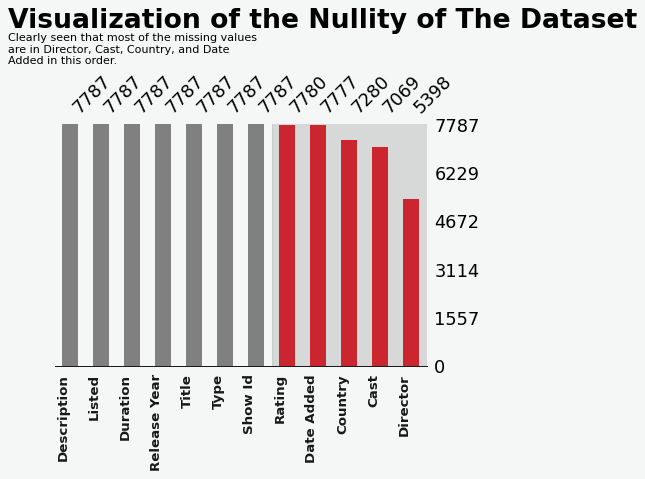

In [7]:
fig, ax = plt.subplots(dpi = 80)
ax.set_facecolor('#f5f6f6')
fig.patch.set_facecolor('#f5f6f6')

color = ['grey','grey','grey','grey','grey','grey','grey','#E50914','#E50914','#E50914','#E50914','#E50914']
msno.bar(df,fontsize =16, color = color, sort = 'descending', ax = ax, figsize = (12,6))
labels = ['Description','Listed','Duration', 'Release Year', 'Title', 'Type','Show Id','Rating', 'Date Added','Country', 'Cast','Director']
ax.set_xticklabels(labels,{'color':'black','weight':'bold','size':12}, alpha = 0.9,rotation = 90)
ax.text(-2,1.4,'Visualization of the Nullity of The Dataset' ,{'color':'black','weight':'bold','size':24})
ax.text(-2,1.25,'Clearly seen that most of the missing values \nare in Director, Cast, Country, and Date \nAdded in this order.')
ax.axvspan(6.5,12.5,0,7787, color = 'grey', alpha = 0.25)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)
fig.show()

Our missing number plots shows that total four columns have missing values which are director, rating, cast, country, date_added. Most of missing values can be observed in director column, followed by cast column.

filling missing data with following datapoints

1. director - NoDataAvailable
2. cast - NoDataAvailable
3. country - mode of the country series
4. date_added - mode of the date_added
5. rating - mode of the rating

In [12]:
df_orig = df.copy() # copying original dataset 

# handling missing values
df['director'] = df['director'].fillna('NoDataAvailable')
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['cast'] = df['cast'].fillna('NoDataAvailable')
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
print('count of values')
print(df.isna().sum())

count of values
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


In [13]:
# Helper column for various plots
df['count'] = 1

# Lets retrieve just the first country
df['first_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['first_country'].head()

# Rating ages

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# Genre

df['genre'] = df['listed_in'].apply(lambda x :  x.split(',')) 

# Reducing name length

df['first_country'].replace('United States', 'USA', inplace=True)
df['first_country'].replace('United Kingdom', 'UK',inplace=True)
df['first_country'].replace('South Korea', 'S. Korea',inplace=True)

#**Netflix Analysis**

##By Content

In [14]:
x = df.groupby(['type'])['type'].count()
y = len(df)
r = ((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

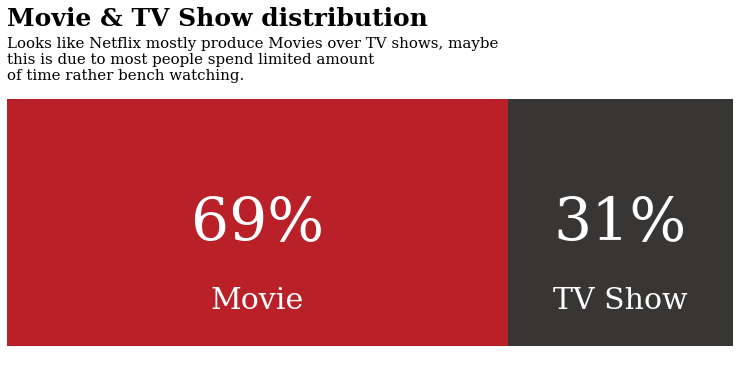

In [15]:
fig, ax = plt.subplots(1,1,figsize=(13, 5))

ax.barh(mf_ratio.index, mf_ratio['Movie'], 
        color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], 
        color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])


# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=30, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=30, fontweight='light', fontfamily='serif',
                   color='white')






# Title & Subtitle
fig.text(0.125,1.05,'Movie & TV Show distribution', fontfamily='serif',fontsize=25, fontweight='bold')
fig.text(0.125,0.9,'Looks like Netflix mostly produce Movies over TV shows, maybe \nthis is due to most people spend limited amount \nof time rather bench watching.',fontfamily='serif',fontsize=15) 
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

## By Country

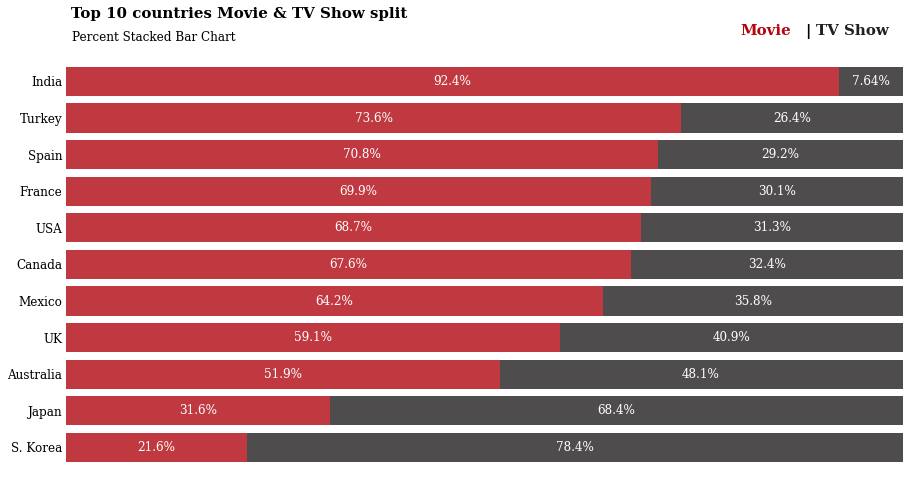

In [16]:
country_order = df['first_country'].value_counts()[:11].index
data_q2q3 = df[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]




###
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.93, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')



ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [17]:
data = df.groupby('first_country')['count'].sum().sort_values(ascending=False)[:20]

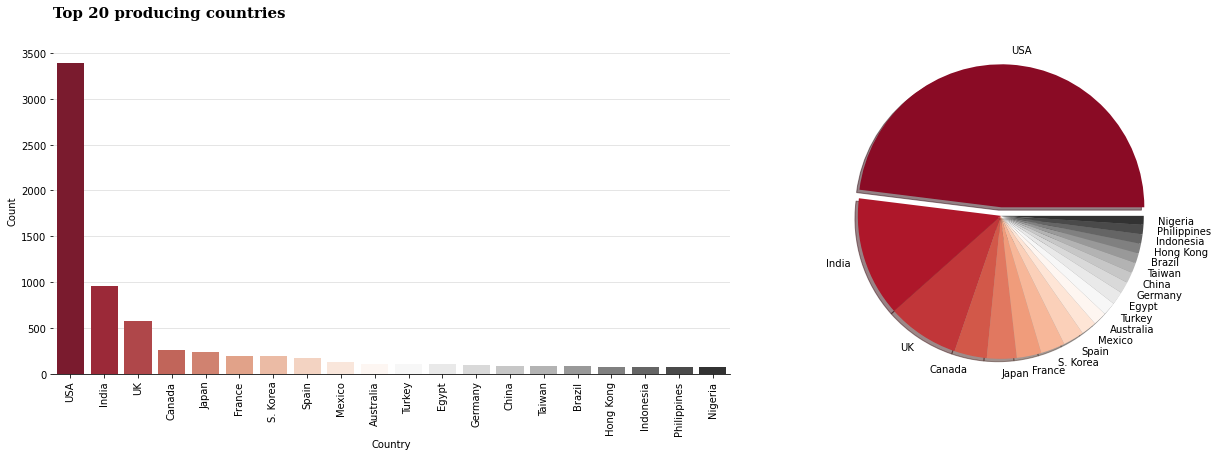

In [18]:
from matplotlib import gridspec

top20_country = data[:20]

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 5])

fig.text(0.125, 0.95, 'Top 20 producing countries', fontsize=15, fontweight='bold', fontfamily='serif')
ax = plt.subplot(gs[0])
sns.barplot(top20_country.index, top20_country, ax=ax, palette="RdGy")
ax.set_xticklabels(top20_country.index, rotation='90')


ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 4000, 500) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

explode = [0 for _ in range(20)]
explode[0] = 0.06

ax2 = plt.subplot(gs[1])
ax2.pie(top20_country, labels=top20_country.index,
        shadow=True, startangle=0, explode=explode,
        colors=sns.color_palette("RdGy", n_colors=20)
       )
ax2.axis('equal') 

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.set(xlabel='Country', ylabel='Count')
plt.show()

The most prolific producers of
content for Netflix are, primarily,
the USA, with India and the UK
a significant distance behind.

It makes sense that the USA produces 
the most content as, afterall, 
Netflix is a US company.


In [19]:
country = df.country.value_counts()

coun = {}
for idx, val in country.items():
    l = idx.split(',')
    for i in l:
        i = i.strip()
        if i in coun.keys():
            d = {}
            d[i] = val + coun[i]
            coun.update(d)
        else:
            d = {i:val}
            coun.update(d)

nation, count = [],[]
for idx, val in coun.items():
    nation.append(idx)
    count.append(val)

temp = (pd.DataFrame({'country':nation, 'count': count})
        .sort_values('count', ascending = False))

West Germany not found in regex
 not found in regex
Soviet Union not found in regex
East Germany not found in regex


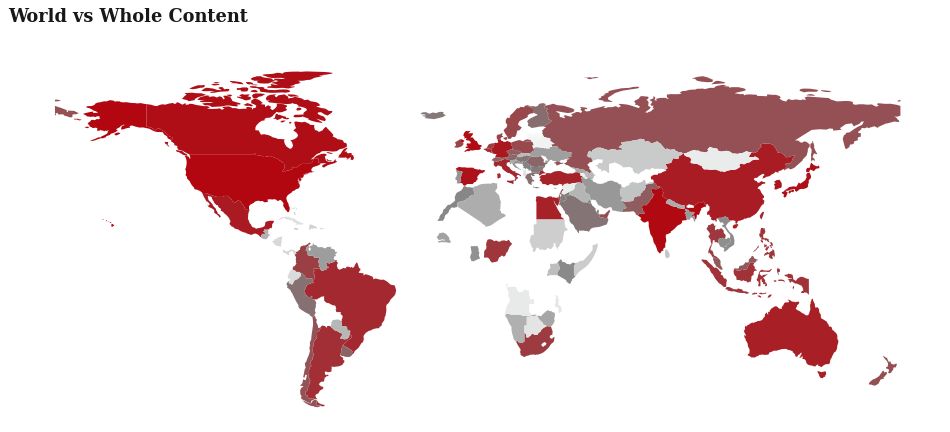

In [20]:
temp['color'] = temp['count'].apply(lambda x : '#b20710' if x > temp['count'].values[30] else 'grey')

#loading geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#converting country names to iso codes
temp['iso_code'] = coco.convert(names=temp['country'], to ='ISO3')
temp = temp[temp['iso_code'] != 'not found']

# merging geodataframe and pandas dataframe
temp_map = world.merge(temp,left_on = 'iso_a3', right_on = 'iso_code')

temp_map.drop(columns = ['continent', 'gdp_md_est','pop_est','name',], inplace = True)
temp_map = temp_map.sort_values(by = 'count', ascending = False)


#viualization
colors = ['#b20710','grey','#f8f9f9',]
cmap  = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)

fig, ax  = plt.subplots(figsize = (15,7.5), dpi = 80)
temp_map.dropna().plot(column = 'count', 
                       color = temp_map.dropna()['color'], 
                       cmap = cmap,
                       scheme='quantiles', 
                       k=10, legend = False,
                       ax = ax)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.text(-200,104,'World vs Whole Content', {'fontfamily':'serif', 'size':16, 'weight':'bold'}, alpha = 0.9)
fig.show()

World map show the contry wise production of content, seems like mostly contries in africa are least contributing to the content. Where as most of the developed countries are being on top

Interestingly, Netflix in India
is made up nearly entirely of Movies. 

Bollywood is big business, and perhaps
the main focus of this industry is Movies
and not TV Shows.

South Korean Netflix on the other hand is 
almost entirely TV Shows.

The underlying resons for the difference 
in content must be due to market research
conducted by Netflix.

##By time


###By Year

In [21]:
TV = df[df['type'] == 'TV Show'].release_year.value_counts()
Movie = df[df['type'] == 'Movie'].release_year.value_counts()

# creating a dataframe

Tv_df = pd.DataFrame({'year': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'year': Movie.index, 'Movie_count': Movie.values})

rel_data = pd.merge(Tv_df, Movie_df, how = 'right', on = 'year')
rel_data.fillna('0', inplace = True)
rel_data['Tv_count'] = rel_data.Tv_count.astype('int64')
rel_data = rel_data.sort_values('year', ascending = False).reset_index(drop = True)

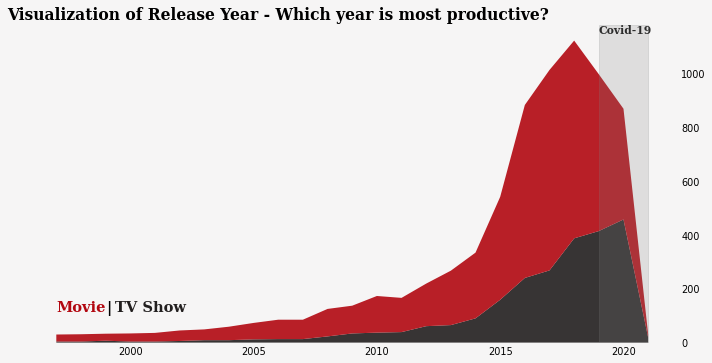

In [22]:
## visualization

fig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

labels = [ 'TV shows', 'Movies ']

# stackplot
ax.stackplot(rel_data.year[0:25], rel_data.Tv_count[0:25],rel_data.Movie_count[0:25],labels =labels, 
              colors = ['#221f1f','#b20710',], baseline = 'zero', alpha = 0.9 )

# Region of interest
 
ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019, 1147, 'Covid-19', {'fontfamily':'serif', 'fontsize': '11', 'color': 'black', 'weight':'bold'},alpha = 0.8)


#title
 
ax.text(1995,1200, 'Visualization of Release Year - Which year is most productive?',
                      {'fontfamily':'serif', 'fontSize':'16', 'weight': 'bold','color': 'black'})

plt.box(on = None)
ax.yaxis.tick_right()

ax.tick_params(axis=u'both', which=u'both',length=0)

fig.text(0.16,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.22,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.23,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

# ax.axes.get_yaxis().set_visible(False)
fig.show()

Release of content was happening from way back 1925, but here that data was truncated as it is out of scope of this analysis. From the plot it is clear that entertainment industry mostly favoured movies till last decade, but things are changing and focus shifting towards shows as well. It is clear from the plot that covid did effected entertaiment industry significataly. Since past decade, both movies and tv shows gain popularity and most of the content is in the category of movies.

In [23]:
df['year_added'] = df['date_added'].apply(lambda x :  x.split(',')[-1])
df['year_added'] = df['year_added'].apply(int)

In [24]:
df['country'] = df['country'].dropna().apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
lst_col = 'country'
data2 = pd.DataFrame({
      col :  np.repeat(df[col].values, df[lst_col].str.len())
      for col in df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns.tolist()]

In [25]:
year_country2 = data2.groupby('year_added')['country'].value_counts().reset_index(name='counts')

fig = px.choropleth(year_country2, locations="country", color="counts", 
                    locationmode='country names',
                    animation_frame='year_added',
                    range_color=[0,200],
                    color_continuous_scale=px.colors.sequential.OrRd
                   )

fig.update_layout(title='Comparison by country')
fig.show()

###By month

In [26]:
df["date_added"] = pd.to_datetime(df['date_added'])
df['month_added']=df['date_added'].dt.month
df['month_name_added']=df['date_added'].dt.month_name()

In [27]:
month_order = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

df['month_name_added'] = pd.Categorical(df['month_name_added'], categories=month_order, ordered=True)

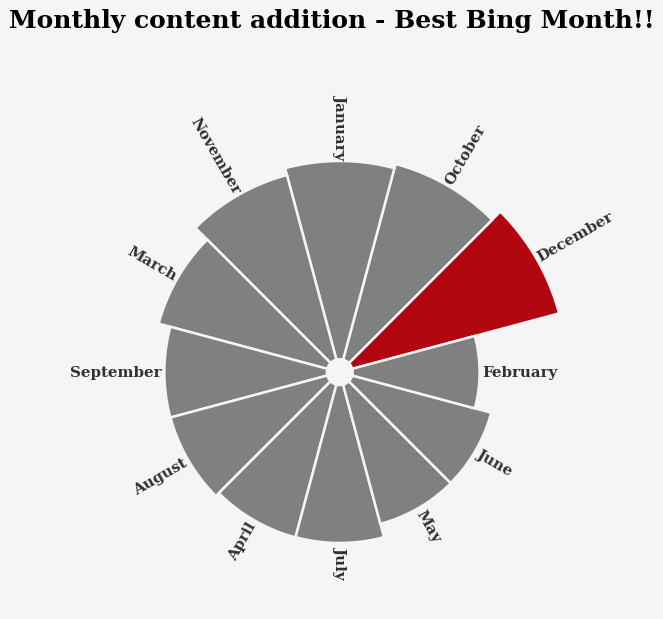

In [28]:
added_month = df['month_added'].value_counts()

# initialize the figure
fig = plt.figure(figsize=(14,7), dpi = 90)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
ax = plt.subplot(polar=True)
plt.axis('off')


## labels
label_map = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
lab = added_month.index
labels = lab.map(label_map)

colors = ['#b20710', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey','grey']


# Constants = parameters controling the plot layout:
upperLimit = 1000
lowerLimit = 50
labelPadding = 10

# Compute max and min in the dataset
max = added_month.max()

slope = (max - lowerLimit) / max
heights = slope * added_month.values + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(added_month.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(added_month)+1))
angles = [element * width for element in indexes]


# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="#f6f5f5",
    color = colors,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, labels):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",**{'fontfamily':'serif', 'size':12, 'weight':'bold','color':'black'},alpha = 0.8) 

fig.text(0.25,1.05,'Monthly content addition - Best Bing Month!!',{'fontfamily':'serif', 'size':20, 'weight':'bold','color':'black'})
fig.show()


Christmas is real holiday!! most of the content was adding to platfrom at the end of the year for holiday season

##Target age

In [29]:
data = df.groupby('first_country')[['first_country','count']].sum().sort_values(by='count',ascending=False).reset_index()[:10]
data = data['first_country']


df_heatmap = df.loc[df['first_country'].isin(data)]

In [30]:
df_heatmap = pd.crosstab(df_heatmap['first_country'],df_heatmap['target_ages'],normalize = "index").T

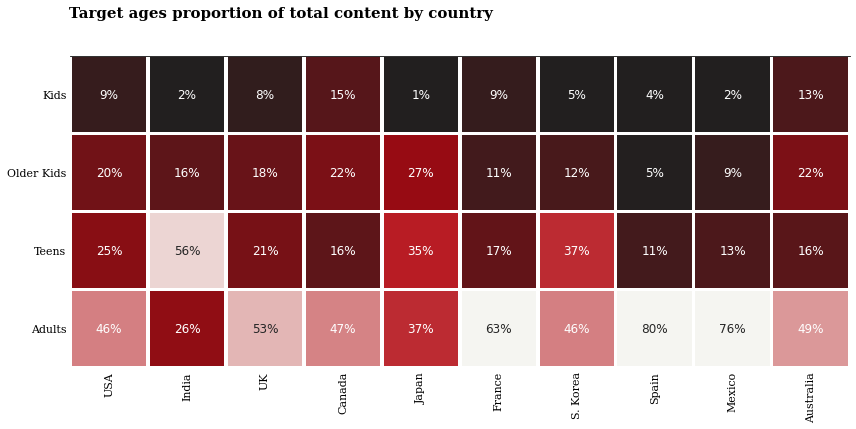

In [31]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

country_order2 = ['USA', 'India', 'UK', 'Canada', 'Japan', 'France', 'S. Korea', 'Spain',
       'Mexico', 'Australia']

age_order = ['Kids','Older Kids','Teens','Adults']

sns.heatmap(df_heatmap.loc[age_order,country_order2],cmap=cmap,square=True, linewidth=2.5,cbar=False,
            annot=True,fmt='1.0%',vmax=.6,vmin=0.05,ax=ax,annot_kws={"fontsize":12})

ax.spines['top'].set_visible(True)


fig.text(.575, .725, 'Target ages proportion of total content by country', fontweight='bold', fontfamily='serif', fontsize=15,ha='right')   

ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()

As we can see on the figure, Children's content is always the least in all countries, while the majority of the show is for Adults. One special case is India, where the content here focuses mainly on teenagers.

In [32]:
rating_order =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']

df_movies = df[df['type']=='Movie']
df_tv = df[df['type']=='TV Show']

df_tv_rate = pd.DataFrame(df_tv['rating'].value_counts())
missing_rate = ['G', 'PG', 'PG-13', 'NC-17']
for i in missing_rate:
  df_tv_rate.loc[i] = 0

movie_rating = df_movies['rating'].value_counts()[rating_order]
tv_rating = df_tv_rate['rating'][rating_order]

In [33]:
def rating_barplot(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1,1, figsize=(15, 7))
    if h_lim :
        ax.set_ylim(0, h_lim)
    

    color =  ['black', '#302f2c', '#d92b35', '#7a060c']
    span_range = [[0, 2], [3,  6], [7, 8], [9, 11]]

    for idx, sub_title in enumerate(['Little Kids', 'Older Kids', 'Teens', 'Mature']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx])/2 ,height),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.5)
    ax.bar(data.index, data,  color="#943535", width=0.6, edgecolor='#943535')

    fig.text(.35, 0.91, f'Distribution of {title} Rating', fontweight='bold', fontfamily='serif', fontsize=15,ha='right')
    plt.show()

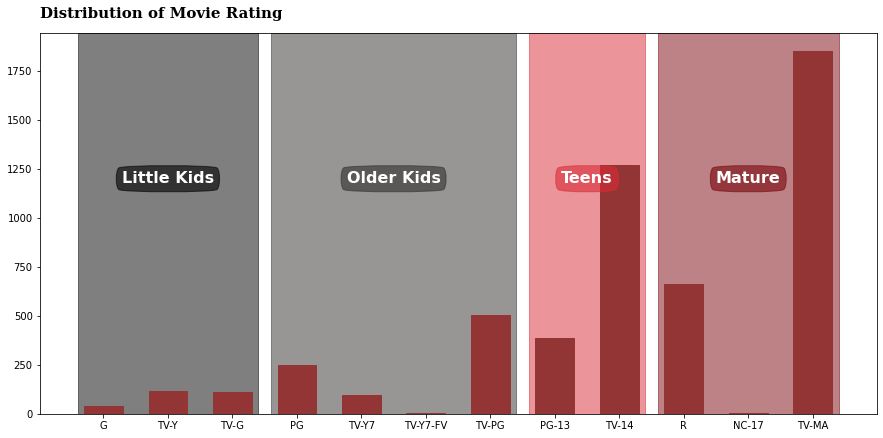

In [34]:
rating_barplot(movie_rating,'Movie', 1200)

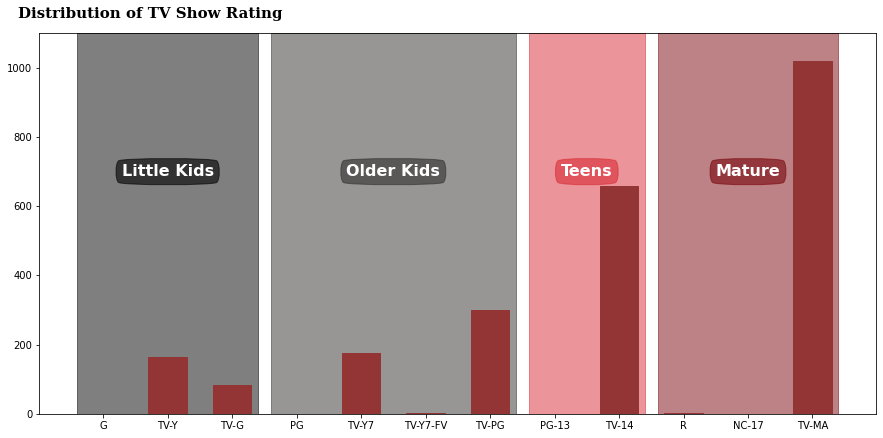

In [35]:
rating_barplot(tv_rating,'TV Show' , 700, 1100)

Certainly the TV Show is more for young children. Perhaps more so with the introduction of netflix on home TVs.

##Duration

In [36]:
import plotly.figure_factory as ff
a = df_movies['duration'].str.extract('(\d+)',expand=False).str.strip().astype('float')
fig = ff.create_distplot([a], ['duration'], bin_size=0.7, curve_type='normal', colors=["#b20710"])
fig.update_layout(template='none', font=dict(
        family="serif",
        size=15), title='Distplot with Normal distribution for Movies')
fig.show()

So, a good amount of movies on Netflix are among the duration of 75-120 mins. It is acceptable considering the fact that a fair amount of the audience cannot watch a 3 hour movie in one sitting.

##Genres

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer 

In [38]:
## genere count 

def genere(what):
    if what == 'all':
        genere = df.listed_in.value_counts()
    else:
        genere = df[df['type'] == what].listed_in.value_counts()
    gener = {}
    
    for idx, val in genere.items():
        l = idx.split(',')
        for i in l:
            i = i.strip()
            if i in gener.keys():
                d = {}
                d[i] = val + gener[i]
                gener.update(d)
            else:
                d = {i:val}
                gener.update(d)
    theme, count = [],[]
    
    for idx, val in gener.items():
        theme.append(idx)
        count.append(val)
    
    list_temp = (pd.DataFrame({'genere':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)
    
    return list_temp
tv_genere = genere('TV Show')
mov_genere = genere('Movie')

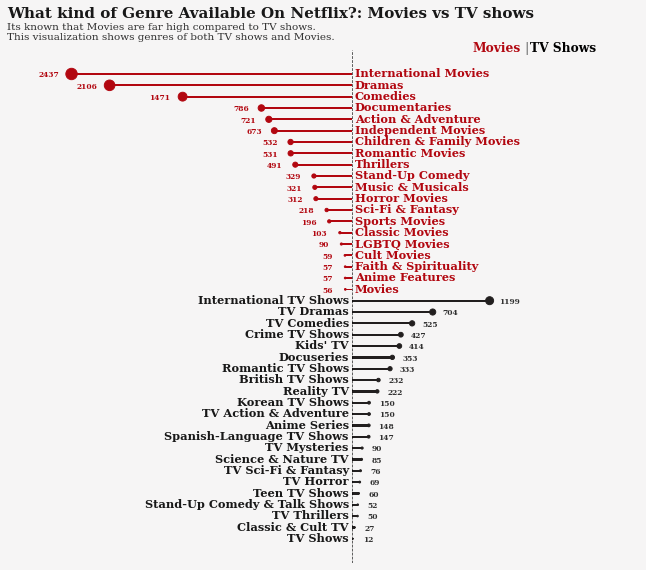

In [39]:
fig, ax  = plt.subplots(figsize = (12,10), dpi =68)

colors = ['#b20710']
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh( y = tv_genere['genere'], width = tv_genere['count'], height = 0.2, color = ['#221f1f'], zorder=0)
ax.scatter( y = tv_genere['genere'], x =  tv_genere['count'], s = tv_genere['count'] * 0.06, c = '#221f1f', zorder=5)

ax.barh( y = mov_genere['genere'], width = - mov_genere['count'], height = 0.15, color = ['#b20710'], zorder=0)
ax.scatter( y = mov_genere['genere'], x =  - mov_genere['count'], s=mov_genere['count']*0.06 , c = '#b20710', zorder=5)

ax.axvline(x = 0, ymin = 0, ymax = 1, **{'linewidth':0.8, 'linestyle': '--', 'color' : 'black'}, alpha = 0.8)

tv_index = tv_genere['genere']
mov_index = mov_genere['genere']

tv_count = tv_genere['count']
mov_count = mov_genere['count']

for y_loc in range(0,22):
        ax.text(-25, y_loc - 0.25 , tv_index[y_loc],horizontalalignment= 'right',**{'fontfamily':'serif', 'size':12, 'weight':'bold', 'color':'black'}, alpha = 0.9)
        ax.text(tv_count[y_loc] + 85, y_loc - 0.25, tv_count[y_loc],horizontalalignment= 'left',**{'fontfamily':'serif', 'size':8, 'weight':'bold', 'color':'black'}, alpha = 0.8)
        
        
for y_loc in range(0,20):
        ax.text(25, 22+y_loc - 0.25, mov_index[y_loc],horizontalalignment = 'left',**{'fontfamily':'serif', 'size':12, 'weight':'bold', 'color':'#b20710'}, alpha =1)
        ax.text(-mov_count[y_loc] - 110,  22 + y_loc - 0.25 , mov_count[y_loc],horizontalalignment= 'right',**{'fontfamily':'serif', 'size':8, 'weight':'bold', 'color':'#b20710'}, alpha =1)
    
for loc in ['left', 'right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_xlim([-3000,2500])

ax.text(-3000, 46, 'What kind of Genre Available On Netflix?: Movies vs TV shows',{'fontfamily':'serif', 'size':16, 'weight':'bold', 'color':'black'}, alpha = 0.9)
ax.text(-3000, 44, 'Its known that Movies are far high compared to TV shows. \nThis visualization shows genres of both TV shows and Movies.',{'fontfamily':'serif', 'size':11, 'color':'black'}, alpha = 0.8)

ax.text(1050, 43, 'Movies',{'fontfamily':'serif', 'size':13, 'color':'#b20710', 'weight':'bold'}, alpha = 1)
ax.text(1500, 43, '|',{'fontfamily':'serif', 'size':13, 'color':'grey','weight':'bold'}, alpha = 1)
ax.text(1550, 43, 'TV Shows',{'fontfamily':'serif', 'size':13, 'color':'black', 'weight':'bold'}, alpha = 1)

fig.show()

In [40]:
import matplotlib.colors


# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])



def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.text(.54,.88,'Genre correlation', fontfamily='serif',fontweight='bold',fontsize=15)
    fig.text(.75,.665,
            '''
             It is interesting that Independant Movies
             tend to be Dramas. 
             
             Another observation is that 
             Internatinal Movies are rarely
             in the Children's genre.
             ''', fontfamily='serif',fontsize=12,ha='right')
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    
    plt.show()

There are 20 types in the Netflix Movie Dataset


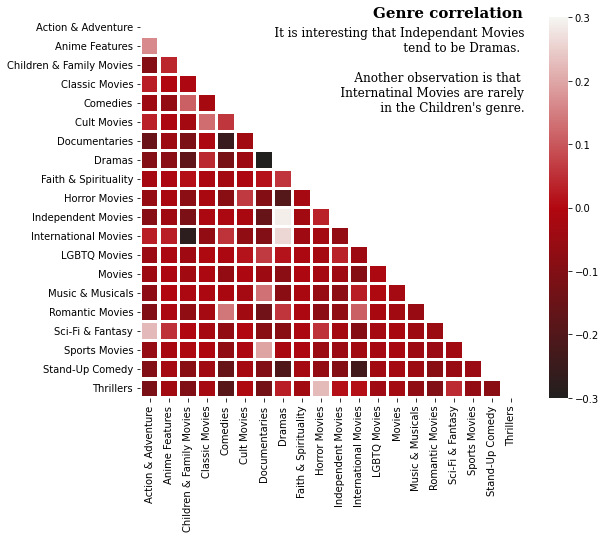

In [41]:
genre_heatmap(df_movies, 'Movie')
plt.show()

##WordCloud for titles

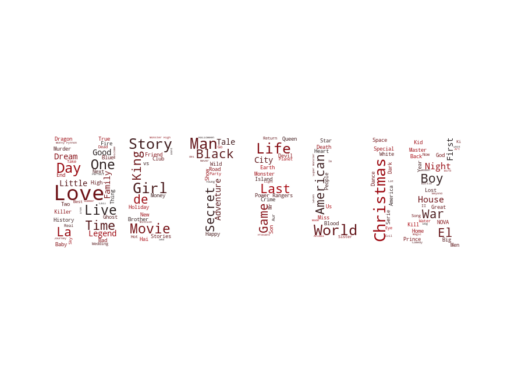

In [42]:
from wordcloud import WordCloud
import random
from PIL import Image
import matplotlib

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

text = str(list(df['title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('/content/750_netflix.jpg'))

wordcloud = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150, mask = mask).generate(text)

plt.figure( figsize=(7,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#Sum up

- Netflix contents have 2 distinct types: Movies and TV Movies. Of which, 69% are movies and 31% are TV Shows.

- The three countries with the largest film production industries are USA, India and the UK. In which, the US completely outperforms the rest, accounting for 43% of the total number of contents available on Netflix.

- Considering the ratio of Movies and TV Shows of each country, it can be seen that in countries like Korea and Japan, the percentage of TV Shows accounts for the majority while Movies dominate in India.

- Movies began to be added to Netflix in the early 1925s and really exploded around 2014 onward. As of now, 2017 is the year with the most contents released.

- Covid has also greatly affected the number of movies released in recent years

- December is the month where the most movies are added. This can be explained by the two biggest holidays of the year, Christmas and New Year, both in this month.

- Children's content is mostly at least in all countries, while the majority of shows is intended for Adults. A special case is in India, where the content here is mainly focused on teenagers.

- The duration of the movies with the largest concentration ranges from 75-120 minutes and is almost normally distributed

- The 3 most popular movie genres in both TV Shows and Movies are International Films, Dramas and Comedies, respectively.

#Contribution


- **Nguyễn Sơn Tùng (Leader)**: *Visualize dữ liệu, làm slide và thuyết trình (nếu có)* - 33%
- **Đỗ Thị Thanh Huế**: *Xử lý dữ liệu và viết tổng kết nội dung* - 33%
- **Phạm Đức Hiếu Thành**: *Chuẩn bị dữ liệu và tìm hiểu cách trình bày nội dung* - 33%